In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [13]:
# Load and encode data
df = pd.read_csv('/home/myoui/shared/ML/gene_list_para.csv')
label_encoder = LabelEncoder()
df['gene_type_encoded'] = label_encoder.fit_transform(df['gene_type'])
vectorizer = CountVectorizer()
X_kmers = vectorizer.fit_transform(df['kmers']).toarray()
X_numerical = df[['gc_content', 'seq_length', 'mfe', 'dot_count', 'bracket_count']].values

In [14]:
# Encode sequences
sequence_map = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
X_sequence = df['sequence'].apply(
    lambda seq: [sequence_map.get(base, 0) for base in seq]
)
max_seq_length = 1000  # Adjust based on dataset
X_sequence = np.array([np.pad(seq[:max_seq_length], (0, max(0, max_seq_length - len(seq))), 'constant') for seq in X_sequence])

# Combine k-mer and numerical features
X_kmer_numerical = np.hstack([X_kmers, X_numerical])

In [15]:
# Sequences with length above 750
above750 = df[df['seq_length'] > 750]
counts_750 = above750['gene_type'].value_counts()
print(counts_750)

gene_type
lncRNA    1119
snoRNA       2
Name: count, dtype: int64


In [16]:
# Sequences with length above 1000
above1000 = df[df['seq_length'] > 1000]
counts_1000 = above1000['gene_type'].value_counts()
print(counts_1000)

gene_type
lncRNA    729
Name: count, dtype: int64


In [17]:
# Train-test split
X_train_kmer, X_test_kmer, X_train_seq, X_test_seq, y_train, y_test = train_test_split(
    X_kmer_numerical, X_sequence, df['gene_type_encoded'], test_size=0.2, random_state=42
)

# Scale k-mer and numerical features
scaler = StandardScaler()
X_train_kmer = scaler.fit_transform(X_train_kmer)
X_test_kmer = scaler.transform(X_test_kmer)

In [18]:
# Define Dataset class
class GeneDataset(Dataset):
    def __init__(self, X_kmer, X_seq, y):
        self.X_kmer = torch.tensor(X_kmer, dtype=torch.float32)
        self.X_seq = torch.tensor(X_seq, dtype=torch.long)
        self.y = torch.tensor(y.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_kmer[idx], self.X_seq[idx], self.y[idx]

# DataLoaders
train_dataset = GeneDataset(X_train_kmer, X_train_seq, y_train)
test_dataset = GeneDataset(X_test_kmer, X_test_seq, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
# Model definition
class HybridLSTM(nn.Module):
    def __init__(self, kmer_input_size, seq_vocab_size, seq_embed_size, seq_hidden_size, num_classes):
        super(HybridLSTM, self).__init__()
        # K-mer and numerical features branch
        self.fc_kmer = nn.Sequential(
            nn.Linear(kmer_input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Sequence LSTM branch
        self.embedding = nn.Embedding(seq_vocab_size, seq_embed_size, padding_idx=0)
        self.lstm = nn.LSTM(seq_embed_size, seq_hidden_size, batch_first=True, bidirectional=True)
        
        # Combined layers
        self.fc_combined = nn.Sequential(
            nn.Linear(128 + 2 * seq_hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x_kmer, x_seq):
        x_kmer_out = self.fc_kmer(x_kmer)
        
        # Process sequence with LSTM
        x_seq_embed = self.embedding(x_seq)
        _, (h_n, _) = self.lstm(x_seq_embed)
        x_seq_out = torch.cat((h_n[0], h_n[1]), dim=1) 
        
        # Concatenate and classify
        x_combined = torch.cat([x_kmer_out, x_seq_out], dim=1)
        output = self.fc_combined(x_combined)
        return output

In [20]:
# Model parameters
kmer_input_size = X_train_kmer.shape[1]
seq_vocab_size = len(sequence_map) + 1  
seq_embed_size = 64
seq_hidden_size = 128
num_classes = len(label_encoder.classes_)

# Model instantiation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridLSTM(kmer_input_size, seq_vocab_size, seq_embed_size, seq_hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_kmer, X_seq, labels in train_loader:
            X_kmer, X_seq, labels = X_kmer.to(device), X_seq.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_kmer, X_seq)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

In [22]:
# Evaluate function
def evaluate_model_with_classification_report(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for X_kmer, X_seq, labels in test_loader:
            X_kmer, X_seq, labels = X_kmer.to(device), X_seq.to(device), labels.to(device)
            outputs = model(X_kmer, X_seq)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    print(classification_report(all_labels, all_predictions, target_names=label_encoder.classes_))
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Epoch 1/20, Loss: 0.3766
Epoch 2/20, Loss: 0.1081
Epoch 3/20, Loss: 0.0465
Epoch 4/20, Loss: 0.0247
Epoch 5/20, Loss: 0.0156
Epoch 6/20, Loss: 0.0218
Epoch 7/20, Loss: 0.0205
Epoch 8/20, Loss: 0.0357
Epoch 9/20, Loss: 0.0146
Epoch 10/20, Loss: 0.0156
Epoch 11/20, Loss: 0.0107
Epoch 12/20, Loss: 0.0158
Epoch 13/20, Loss: 0.0096
Epoch 14/20, Loss: 0.0099
Epoch 15/20, Loss: 0.0083
Epoch 16/20, Loss: 0.0095
Epoch 17/20, Loss: 0.0210
Epoch 18/20, Loss: 0.0137
Epoch 19/20, Loss: 0.0086
Epoch 20/20, Loss: 0.0167
              precision    recall  f1-score   support

      lncRNA       0.99      0.97      0.98       418
       miRNA       0.83      0.91      0.87       388
    misc_RNA       0.98      0.90      0.94       479
       snRNA       0.98      0.97      0.97       376
      snoRNA       0.78      0.83      0.80       198

    accuracy                           0.92      1859
   macro avg       0.91      0.92      0.91      1859
weighted avg       0.93      0.92      0.93      1859



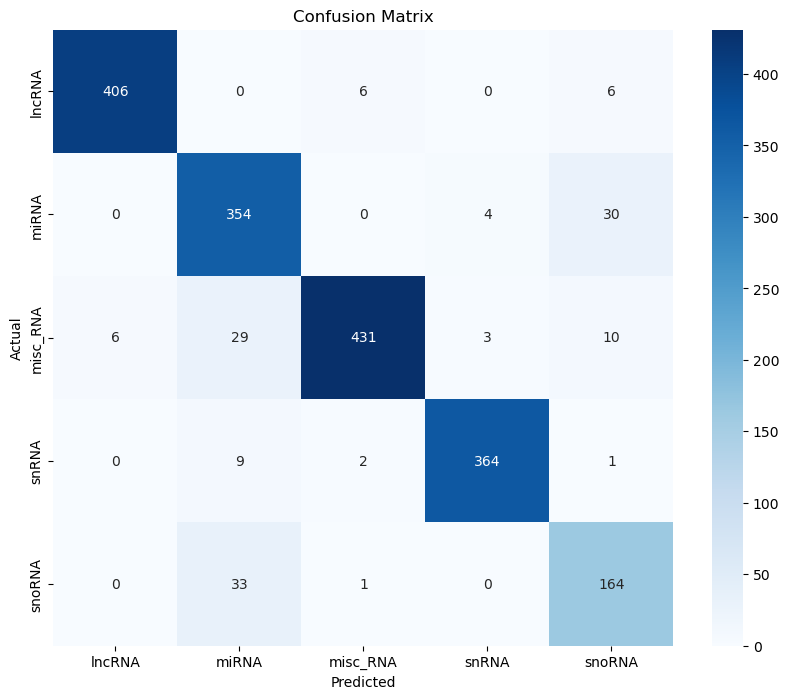

In [23]:
# Train and evaluate
train_model(model, train_loader, criterion, optimizer, epochs=20)
evaluate_model_with_classification_report(model, test_loader)